In [187]:
from iminuit import Minuit
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import scipy
from scipy.optimize import minimize, rosen, rosen_der
from scipy.special import factorial
import scipy.integrate as integrate
from scipy.integrate import quad
from itertools import starmap
from scipy import optimize
import corner
import time
from mpl_toolkits import mplot3d
import healpy as hp
from scipy import nan
import dark_matter_jfactors as dmj
import math
import random
import importlib
from pymultinest.solve import solve
import pymultinest
import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import scipy.interpolate
import json
from os import walk
import re

In [188]:
filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']

#need to get an array like the files, with one value that isn't zero

hdu = readfile(filelist[0])
testarr = reshape_file(hdu, 3, inner20 = False)

#set all values to zero
testarr_zeroes = testarr*0
testarr_zeroes[98559] = 100

#find the one value closest to the center of the array, using b and l
numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
NSIDE = int(hdu[0].header['NSIDE'])


degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
rads = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = False)


#map_ring = hp.pixelfunc.reorder(testarr_zeroes, inp='NEST', out='RING')

theta = 10

#1.518 for 10
#1.508 for 20
#1.5 for 30
#1.696 for 1



convolved = hp.sphtfunc.smoothing(testarr_zeroes, sigma = np.radians(theta)/1.518)

#hp.mollview(convolved, cmap = 'Greys', coord = 'G')

#print(rads[0][98559], rads[1][98559])

vec = hp.ang2vec(rads[0][98559], rads[1][98559])
ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(theta), inclusive = False)
ipix_disc2 = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(2*theta), inclusive = False)
#ipix_disc_true = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(theta), inclusive = True)


testing_convolved = np.copy(convolved)/np.sum(convolved)*100

#print(np.nansum(testing_convolved))
print('68.3:')
print(np.nansum(testing_convolved[ipix_disc]))
print('-------')
print('95.5:')
print(np.nansum(testing_convolved[ipix_disc2]))
#print(np.nansum(testing_convolved[ipix_disc_true]))
testing_convolved[ipix_disc] = 0

#hp.mollview(testing_convolved, cmap = 'Greys', coord = 'G')




68.3:
68.29948641494717
-------
95.5:
99.03462658020021


0.004404223765734593
68.22726152948655
95.48915567882062


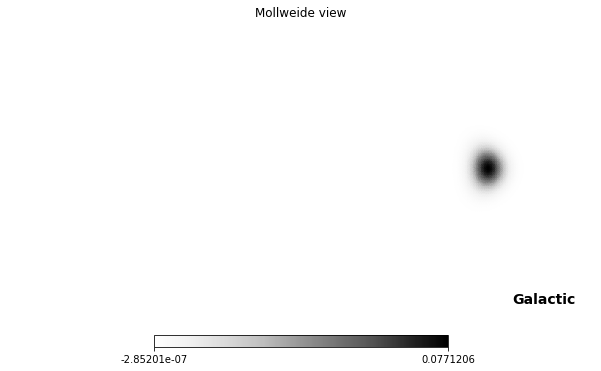

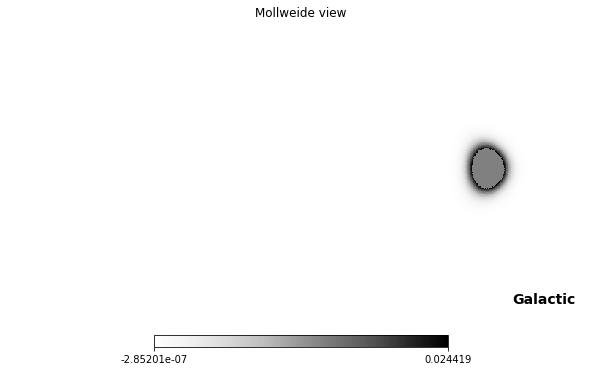

In [195]:
#choose a random value in the sky between 0 and the length of the degree array

theta = 10

sig1 = []
sig2 = []
l_vals = []

for i in range(0, 100):
    hdu = readfile(filelist[0])
    testarr = reshape_file(hdu, 3, inner20 = False)
    
    current_test = random.randint(0, len(degrees[0]))
    rad_x = rads[0][current_test]
    rad_y = rads[1][current_test]
    
    #set all values to zero
    testarr_zeroes = testarr*0
    testarr_zeroes[current_test] = 100
    
    
    convolved = hp.sphtfunc.smoothing(testarr_zeroes, sigma = np.radians(theta)/1.518)
    #convolved = hp.sphtfunc.smoothing(testarr_zeroes, sigma = np.radians(theta))

    convolved = convolved/np.sum(convolved)*100
    #print(sum(convolved))
    print(np.std(convolved))
    
    hp.mollview(convolved, cmap = 'Greys', coord = 'G')
    
    
    vec = hp.ang2vec(rad_x, rad_y)
    ipix_disc_1sig = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(theta), inclusive = False)
    ipix_disc_2sig = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(1.64*theta), inclusive = False)

    if (np.nansum(convolved)<98):
        continue

    
    sigma = np.sum(convolved[ipix_disc_1sig])
    sigma2 = np.sum(convolved[ipix_disc_2sig])
    print(sigma)
    print(sigma2)
        
    convolved[ipix_disc_1sig] = np.nan
    hp.mollview(convolved, cmap = 'Greys', coord = 'G')
    

    break
    
    sig1.append(sigma)
    sig2.append(sigma2)
    l = degrees[0][current_test]
    l_vals.append(l)
    

(95, 100)

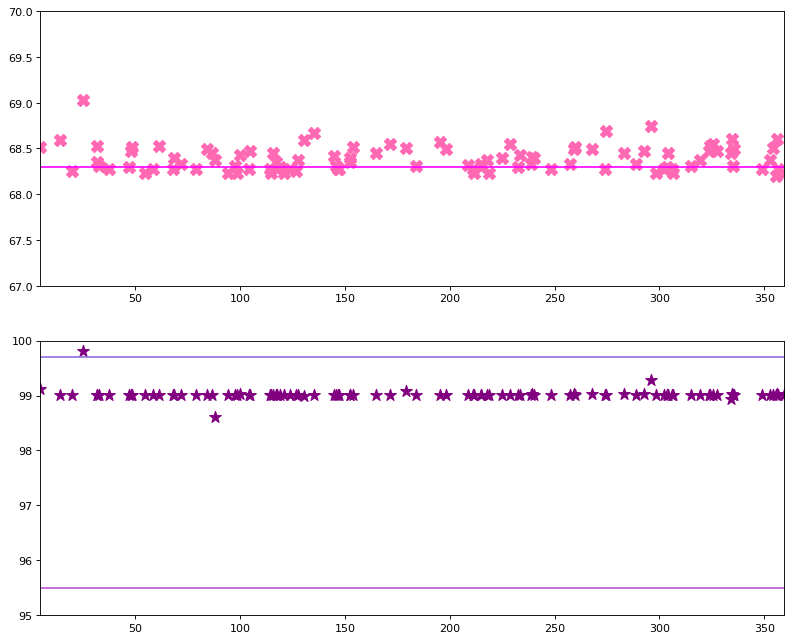

In [148]:
fig, axs = plt.subplots(2, figsize=(12, 10), dpi=80)

axs[0].scatter(l_vals, sig1, color = 'hotpink', marker = 'X', s = 120)
axs[1].scatter(l_vals, sig2, color = 'purple', marker = '*', s = 120)
axs[1].hlines(99.7, np.nanmin(l_vals), np.nanmax(l_vals), color = 'mediumpurple')
axs[0].hlines(68.3, np.nanmin(l_vals), np.nanmax(l_vals), color = 'fuchsia')
axs[1].hlines(95.5, np.nanmin(l_vals), np.nanmax(l_vals), color = 'mediumorchid')
axs[0].set_xlim(np.nanmin(l_vals), np.nanmax(l_vals))
axs[1].set_xlim(np.nanmin(l_vals), np.nanmax(l_vals))
axs[0].set_ylim(67, 70)
axs[1].set_ylim(95, 100)


In [3]:
#need to get an array like the files, with one value that isn't zero
def readfile(filename):
    """
    A simple function to read the maps of a given number n and given filename.
    """
    file_to_read = fits.open(filename)
    return file_to_read

def reshape_file(hdu, n, inner20 = True):
    """
    Reshapes the data to be in the size we want
    """
    
    if inner20:
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        inner_20_pos = np.where(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
        inner_20_neg = np.where(np.sqrt((degrees[0]-360)**2+degrees[1]**2)<= 20)
        testbin = list(hdu[n].data[inner_20_pos])+list(hdu[n].data[inner_20_neg])
        
        #might need this for plotting, not sure
        #data4 = hdu[n].data
        #test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #testbin = np.reshape(test20, (128*3, 1536//3))

    else:
        """
        testbin = np.reshape(hdu[n].data, (128*3, 1536//3))
        
        """
        numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
        NSIDE = int(hdu[0].header['NSIDE'])
        degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
        
        inner_20_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
        inner_20_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
        inner_20 = np.logical_and(inner_20_pos, inner_20_neg)
        
        data4 = hdu[n].data
        test20 = np.copy(data4)
        #test20[inner_20] = np.nan
        #print(sum(~np.isnan(test20)))
        #testbin = np.reshape(test20, (128*3, 1536//3))
        
    return test20

def get_energy_index(E_desired, hdu):
    energy_hdu = np.concatenate(hdu[38].data, axis = 0)
    idx = find_nearest(energy_hdu, E_desired)
    return idx
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    

In [4]:
#need to get an array like the files, with one value that isn't zero

hdu = readfile(filelist[0])
testarr = reshape_file(hdu, 0, inner20 = False)
print(len(testarr))

#set all values to zero
testarr_zeroes = testarr*0

#find the one value closest to the center of the array, using b and l
numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
NSIDE = int(hdu[0].header['NSIDE'])

degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)

total_dist = np.sqrt(degrees[0]**2+degrees[1]**2)
total_dist2 = np.sqrt((degrees[0]-360)**2+degrees[1]**2)
print(np.where(total_dist == np.nanmin(total_dist)))
print(np.where(total_dist2 == np.nanmin(total_dist2)))


196608
(array([97536, 98560]),)
(array([98559]),)


In [5]:
print(degrees[0][97536])
print(degrees[1][97536])
print(degrees[0][98560])
print(degrees[1][98560])
print(360-degrees[0][98559])
print(degrees[1][98559])
#middle at 97536


0.0
0.2984168674869352
0.0
-0.2984168674869352
0.3515625
0.0


In [6]:
testarr_zeroes[97536] = 1
testarr_zeroes[testarr_zeroes != 1] = 0

In [7]:
print(np.min(testarr_zeroes))

0.0


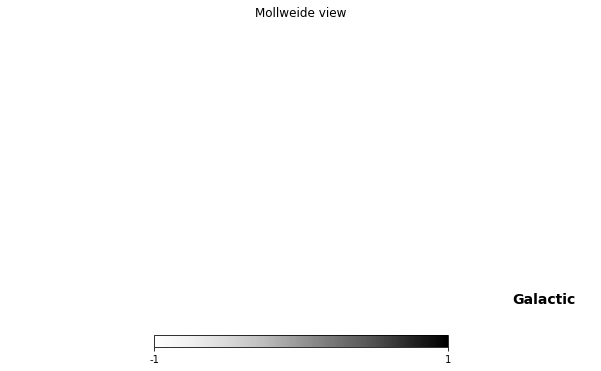

In [8]:
hp.mollview(np.log10(testarr_zeroes), cmap = 'Greys', coord = 'G')


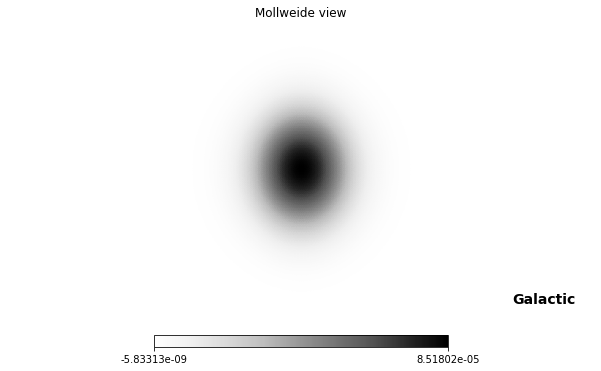

In [9]:
convolved = hp.sphtfunc.smoothing(testarr_zeroes, sigma=np.pi/180*20)
hp.mollview(convolved, cmap = 'Greys', coord = 'G')



1.0001386448203908
0.6829047587563456


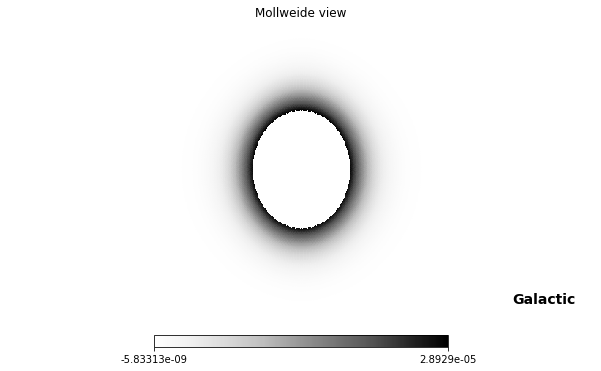

In [11]:
vec = hp.ang2vec(np.pi / 2, 0)
ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(30))

testing_convolved = np.copy(convolved)

print(np.nansum(testing_convolved))
print(np.nansum(testing_convolved[ipix_disc]))
testing_convolved[ipix_disc] = 0

hp.mollview(testing_convolved, cmap = 'Greys', coord = 'G')



In [235]:
print(np.sum(convolved))

1.0001376227334717


In [236]:
fac = -0.2984168674869352
#fac = 0

inner_1_pos = np.argwhere(np.sqrt((degrees[0])**2+(degrees[1]-fac)**2)<= 20)
inner_1_neg = np.argwhere(np.sqrt((degrees[0]-360)**2+(degrees[1]-fac)**2)<= 20)
#where_1deg = np.logical_and(inner_1_pos, inner_1_neg) 
total_sum1 = np.sum(convolved[inner_1_pos]) + np.sum(convolved[inner_1_neg])
print(total_sum1)

print('----------------')


inner_2_pos = (np.sqrt((degrees[0])**2+(degrees[1]-fac)**2)> 2)
inner_2_neg = (np.sqrt((degrees[0]-360)**2+(degrees[1]-fac)**2) > 2)
where_2deg = np.logical_and(inner_2_pos, inner_2_neg)

inner_20_pos = (np.sqrt((degrees[0])**2+(degrees[1]-fac)**2)> 20)
inner_20_neg = (np.sqrt((degrees[0]-360)**2+(degrees[1]-fac)**2) > 20)
where_20deg = np.logical_and(inner_20_pos, inner_20_neg)

convolved_test1 = np.copy(convolved)
convolved_test1[where_1deg] = np.nan
inner1 = np.nansum(convolved_test1)

convolved_test2 = np.copy(convolved)
convolved_test2[where_2deg] = np.nan
inner2 = np.nansum(convolved_test2)

convolved_test20 = np.copy(convolved)
convolved_test20[where_20deg] = np.nan
inner20 = np.nansum(convolved_test20)

print(degrees[0][97536])
print(degrees[1][97536])
print('----------------------------')

print(inner1)
print(inner2)
print(inner20)
print(np.sum(convolved))

0.7641521976647759
----------------
0.0
0.2984168674869352
----------------------------
0.004116960400408142
0.01517401104779803
0.7641521976647759
1.0001376227334717


In [180]:
print(np.nansum(convolved_test20))

0.39770824307455854


In [181]:
print(np.nanmin(convolved_test20))

5.08143002061219e-05


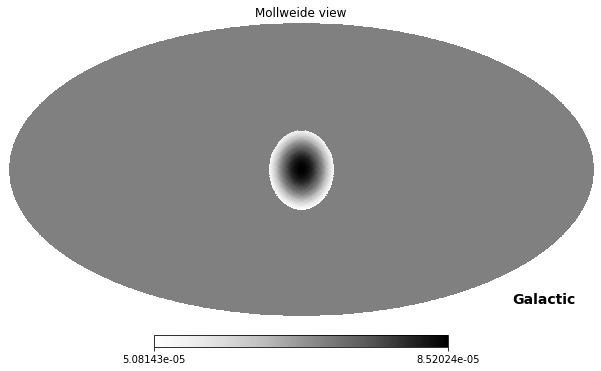

In [197]:
hp.mollview(convolved_test20, cmap = 'Greys', coord = 'G', xsize = 2000)


In [81]:
#find the sums at 1 and 2 deg

one_deg = np.sum(convolved[where_1deg])
two_deg = np.sum(convolved[where_2deg])

print(one_deg)
print(two_deg)


0.36366054552303745
0.8350605235127045
